# Autoencoders on Fashion MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

In [27]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.__version__

# from notebooks.utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'2.6.0+cu124'

In [28]:
# !git clone https://github.com/Esmaeel-Hilal/Generative_Deep_Learning_in_PyTorch.git

In [29]:
# %cd Generative_Deep_Learning_in_PyTorch/
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 414 bytes | 414.00 KiB/s, done.
From https://github.com/Esmaeel-Hilal/Generative_Deep_Learning_in_PyTorch
   f559db2..41dd362  main       -> origin/main
Updating f559db2..41dd362
Fast-forward
 book_implementations_notebooks/engine.py | 3 ++-
 1 file changed, 2 insertions(+), 1 deletion(-)


In [30]:
# imports from the repository
from Generative_Deep_Learning_in_PyTorch.book_implementations_notebooks.utils import display
from Generative_Deep_Learning_in_PyTorch.book_implementations_notebooks.engine import train

In [31]:
torch.cuda.is_available()

True

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# import requests
# from pathlib import Path

# # Download helper functions from Learn PyTorch repo (if not already downloaded)
# if Path("helper_functions.py").is_file():
#   print("helper_functions.py already exists, skipping download")
# else:
#   print("Downloading helper_functions.py")
#   # Note: you need the "raw" GitHub URL for this to work
#   request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
#   with open("helper_functions.py", "wb") as f:
#     f.write(request.content)

helper_functions.py already exists, skipping download


In [9]:
# # Import accuracy metric
# from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

## 0. Parameters <a name="parameters"></a>

In [33]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

## 1. Prepare the data <a name="prepare"></a>

In [34]:
# For the preprocessing step in the original notebook
# We can instead do the following in PyTorch

transform = transforms.Compose([
    transforms.Pad(2),       # Pad to 32x32
    transforms.ToTensor(),   # Normalize to [0,1] and add channel dim
])
# Note: You don't need expand_dims in PyTorch because ToTensor() already converts the grayscale 2D image to a [1, H, W] tensor automatically.

# Load the data
train_dataset = datasets.FashionMNIST(root='fashion_mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='fashion_mnist_data', train=False, download=True, transform=transform)

# Set up the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

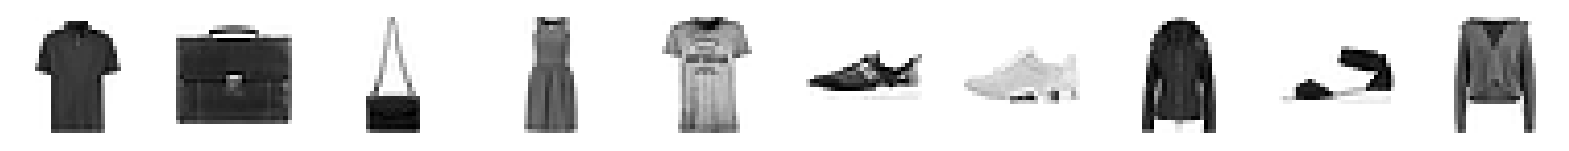

In [35]:
# Show some items of clothing from the training set
images, _ = next(iter(train_dataloader))
display(images, n=10)

**Note:**

- In PyTorch, the batch size and data shuffling are configured when creating the DataLoader, before training begins.
- In contrast, in TensorFlow/Keras, these settings are typically specified in the model.fit() method during training.

## 2. Build the autoencoder <a name="build"></a>

In [36]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_dim=2):
        super(ConvAutoencoder, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(128 * 4 * 4, embedding_dim)

        # Decoder
        self.fc_dec = nn.Linear(embedding_dim, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv_final = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        shape_before_flattening = x.shape[1:]
        x = self.flatten(x)
        embedding = self.fc_enc(x)
        return embedding, shape_before_flattening

    def decode(self, embedding, shape_before_flattening):
        x = self.fc_dec(embedding)
        x = x.view(-1, *shape_before_flattening)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.sigmoid(self.deconv_final(x))
        # x = x[:, :, 2:30, 2:30]
        return x

    def forward(self, x):
        embedding, shape_before_flattening = self.encode(x)
        reconstructed = self.decode(embedding, shape_before_flattening)
        return reconstructed

In [37]:
autoencoder = ConvAutoencoder(embedding_dim=2)
autoencoder

ConvAutoencoder(
  (relu): ReLU(inplace=True)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_enc): Linear(in_features=2048, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=2048, bias=True)
  (deconv1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv_final): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigmoid): Sigmoid()
)

In [38]:
# Set up loss and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## 3. Train the autoencoder <a name="train"></a>

**Note:**

This block attempts to import TensorBoard from PyTorch. If it’s not installed, it automatically installs it using pip and then proceeds. After that, it initializes a `SummaryWriter` with default settings for logging training metrics.


In [39]:
autoencoder_results = train(model=autoencoder,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=10,
                            device=device,
                            compute_accuracy=False,
                            target_fn=lambda X, y: X,
                            save_best=True,
                            use_writer=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Saved better model at epoch 0 with loss 0.2614
Epoch: 1 | train_loss: 0.2890 | train_acc: 0.0000 | test_loss: 0.2614 | test_acc: 0.0000
Saved better model at epoch 1 with loss 0.2560
Epoch: 2 | train_loss: 0.2565 | train_acc: 0.0000 | test_loss: 0.2560 | test_acc: 0.0000
Saved better model at epoch 2 with loss 0.2547
Epoch: 3 | train_loss: 0.2534 | train_acc: 0.0000 | test_loss: 0.2547 | test_acc: 0.0000
Saved better model at epoch 3 with loss 0.2522
Epoch: 4 | train_loss: 0.2515 | train_acc: 0.0000 | test_loss: 0.2522 | test_acc: 0.0000
Saved better model at epoch 4 with loss 0.2517
Epoch: 5 | train_loss: 0.2501 | train_acc: 0.0000 | test_loss: 0.2517 | test_acc: 0.0000
Saved better model at epoch 5 with loss 0.2502
Epoch: 6 | train_loss: 0.2490 | train_acc: 0.0000 | test_loss: 0.2502 | test_acc: 0.0000
Saved better model at epoch 6 with loss 0.2497
Epoch: 7 | train_loss: 0.2483 | train_acc: 0.0000 | test_loss: 0.2497 | test_acc: 0.0000
Saved better model at epoch 7 with loss 0.2493
E

In [45]:
autoencoder_results

{'train_loss': [0.2890359226614237,
  0.2564958422631025,
  0.2534068330874046,
  0.2514544273416201,
  0.250067815259099,
  0.2490298421184222,
  0.24828682616353034,
  0.24753513902425767,
  0.24692339467505614,
  0.246417253986001],
 'train_acc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'test_loss': [0.26143133744597435,
  0.25602407634258273,
  0.25472073510289195,
  0.2522115658223629,
  0.2517462311685085,
  0.2501736783981323,
  0.24966213017702102,
  0.24931252866983414,
  0.24832366928458213,
  0.24798275008797646],
 'test_acc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [40]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))  # ignore labels
train_features_batch = train_features_batch.to(device)
autoencoder.to(device)
autoencoder.eval()
with torch.inference_mode():
    reconstructed = autoencoder(train_features_batch)

In [41]:
reconstructed.shape

torch.Size([100, 1, 32, 32])

In [49]:
import matplotlib.pyplot as plt

def plot_loss_curves(results: dict):
    """
    Plots training and validation loss curves from a results dictionary.

    Args:
        results (dict): A dictionary containing:
                        'train_loss': list of training losses per epoch
                        'test_loss' : list of test losses per epoch
    """
    epochs = range(1, len(results['train_loss']) + 1)

    # train_loss_list = [t.item() for t in results["train_loss"]]
    # test_loss_list = [t.item() for t in results["test_loss"]]

    train_loss_list =  results["train_loss"]
    test_loss_list = results["test_loss"]

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.plot(epochs, train_loss_list, label='Test Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


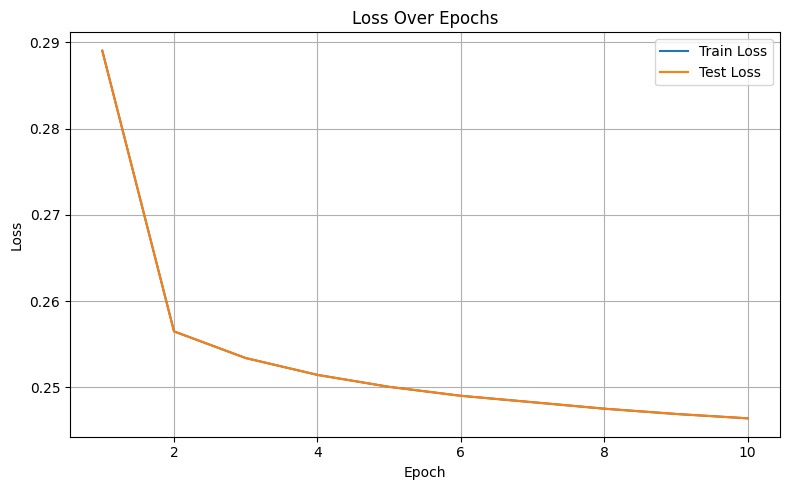

In [50]:
plot_loss_curves(autoencoder_results)

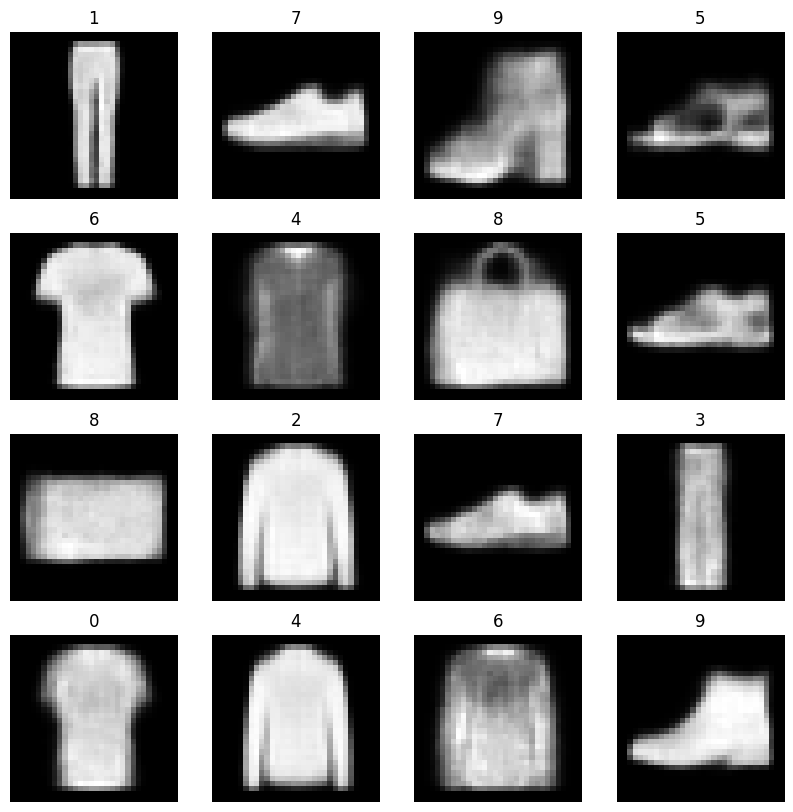

In [48]:
# Plot more images
torch.manual_seed(56)
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    img, label = reconstructed[i][0].cpu(), train_labels_batch[i].item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.show()

In [ ]:
# Add this cell to your notebook and execute it before saving
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.clear_output()'))

<IPython.core.display.Javascript object>